# Esercitazione 2

### Laboratorio di Simulazione Numerica

Il materiale relativo all'esercitazione uno è suddiviso come segue nella cartella `Lab_02`: i codici sono raccolti nelle cartelle `2.1, 2.2`, corrispondenti alle consegne dell'esercitazione; i risultati relativi agli esercizi svolti sono raccolti nella cartella `Results`;

---

Il Jupyter Notebook è organizzato come segue:
- 2.0 caricamento dei pacchetti e introduzione;
- 2.1 stima del valore di un integrale con metodi Monte Carlo;
- 2.2 implementazione di Random Walks e stima della distanza media raggiunta.

## 2.0 - caricamento dei pacchetti e introduzione

I metodi Monte Carlo (MCM) sfruttano il campionamento casuale di variabili per approcciare problemi di vario genere. In questo caso ci concentriamo sul risolvere un problema di integrazione; prendiamo la funzione $$ I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2)dx = 1.$$
L'obiettivo di questo esercizio è stimare il valore di $I$, utilizzando due diverse implementazioni dell'integrazione tramite campionamento MC;
- __uniform sampling:__ queste tecnche di integrazione si basano sul fatto che sia sempre possibile scrivere $I = \int_0^1 g(x)p(x)dx $, ponendo $g(x)$ uguale all'integranda del problema iniziale e assumendo che $p(x)$ sia una distribuzione uniforme distribuita tra $[0,1)$. Secondo questa notazione, sappiamo dunque che $I$ consiste nel valore atteso della variabile $g(x)$ al netto del campionamento di $x$ da $p(x)$. Al crescere della cardinalità del campione delle $x_i$, dunque, è possibile ottenere stime sempre più precise del valore di $I$ calcolandolo come media delle $g(x_i)$ ottenute in corrispondenza delle singole realizzazioni di $x$;
- __importance sampling:__ la seconda tecnica che utilizziamo è un miglioramento della prima e si chiama _importance sampling_. L'idea è questa: estraendo le variabili $x$ da una distribuzione di probabilità più simile all'integranda di quanto non lo sia una $\mathcal{U}[0,1)$ siamo in grado di ottenere stime più precise dell'integrale. In altri termini, se campioniamo le $x$ in modo intelligente (coinvolgendo maggiormente regioni dello spazio campione corrispondenti a valori maggiori dell'integranda) siamo in grado di migliorare le performance dell'integrazione. Ciò che facciamo è allora riscrivere $I$ nel modo seguente: $$ I=\int_0^1 \biggl( \frac{g(x)}{d(x)}\biggr) d(x)dx, $$ dove abbiamo posto $p(x)=1$ per semplicità e come $d(x)$ è opportuno scegliere una funzione che si avvicini quanto più possibile all'integranda. In questo caso, una volta estratto il campione delle $x_i$ a partire dalla $d(x)$, la stima di $I$ può essere calcolata come segue: $$ I = \frac{1}{N}\sum_{i=1}^N \frac{g(x_i)p(x_i)}{d(x_i)}. $$

---

Anche in questa esercitazione le stime delle grandezze vengono effettuate utilizzando il metodo delle medie a blocchi.

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as sc
from scipy.optimize import curve_fit
import matplotlib.cm as cm

sns.set_theme(font_scale=1.7, style='whitegrid') 

#### Caricamento dei risultati

In [185]:
u_samp = np.loadtxt("Results/uniform_sampling.dat")
i_samp = np.loadtxt("Results/importance_sampling.dat")
dis_rw = np.loadtxt("Results/discrete_RW.dat")
con_rw = np.loadtxt("Results/continuum_RW.dat")
block_disc = np.loadtxt("Results/block_on_steps_disc.dat")
block_cont = np.loadtxt("Results/block_on_steps_cont.dat")

## 2.1 - MCM per calcolare l'integrale

In questa sezione espongo i risultati ottenuti nel calcolo dell'integrale $I$ tramite tecniche Monte Carlo. Per entrambe le tecniche ho utilizzato il metodo `blocking` esposto nella relazione relativa all'esercizio uno. In questo caso, la variabile di tipo `Measure*` che viene passata a `blocking` è implementata in modo concreto nella classe `Integrate(..., string integration)`; la variabile di tipo stringa che ho voluto esplicitare è necessaria nel codice per selezionare la tecnica di integrazione che si desidera eseguire: scegliendo il valore `"uniform sampling"` o `"importance sampling"` viene eseguito il calcolo di $I$ utilizzando il metodo selezionato.

---

Ho deciso di eseguire $M=10^4$ stime del valore di $I$, ciascuna ottenuta estraendo $n=100$ variabili casuali dalla distribuzione scelta in base al metodo selezionato. A questo punto ho calcolato $N=100$ misure iterativamente sui blocchi e preso come stima definitiva di $I$ il risultato ottenuto a seguito del contributo dell'ultimo blocco.

---

Specifico la scelta effettuata nel caso della seconda tecnica: ho deciso di scegliere come distribuzione da cui estrarre le variabili casuali utilizzate nel metodo MC la retta: $y=-2x+2$. Sono consapevole della possibilità di scegliere funzioni ancora più performanti, ad esempio uno sviluppo in serie di Taylor del coseno, oppure, essendo nota l'espressione analitica dell'integrale, avrei potuto campionare le variabili MC direttamente da $d(x)=g(x)p(x)/I$. Ciononostante ho preferito operare questa scelta, con l'intenzione di osservare quanto un pur approssimativo miglioramento del campionamento possa influire sulle performance dell'integrazione. Avendo scelto $p(x)=-2x+2$, posso generare le variabili casuali utilizzando il metodo della trasformata; calcolata la c.d.f $F(x)=2x-x^2$, si arriva a dimostrare che, estratto un campione di variabili $r_i$ a partire da $\mathcal{U}[0,1)$, da queste è possibile ottenere un corrispettivo campione estratto da $p(x)$ applicando la trasformazione $x_i = 1+\sqrt{1-r_i}$. ottenuta la nostra $x_i$, possiamo valutare il valore della funzione integranda:

$$ f(x_i)=\frac{g(x_i)\cdot 1}{d(x_i)}=\frac{\pi \cos (\pi x_i /2)}{4(1-x_i)}. $$ 

I risultati ottenuti sono riportati nelle celle seguenti.
#### Integranda e $d(x)$ scelta a confronto

Prima di procedere con l'esposizione dei risultati ottenuti con le simulazioni ho voluto rappresentare graficamente l'integranda esatta e la retta che ho scelto di adottare. 

In [4]:
y = np.linspace(0,1)
f = np.pi/2 * np.cos(np.pi/2 *y)
g = -2*y+2

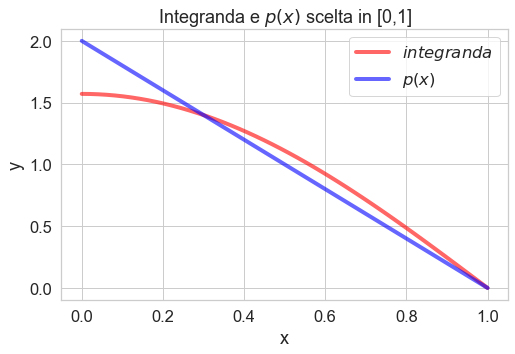

In [15]:
plt.figure(figsize=(8,5))
plt.title('Integranda e $p(x)$ scelta in [0,1]')
plt.plot(y, f, color='red', linewidth=4, alpha=0.6, label='$integranda$')
plt.plot(y, g, color='blue', linewidth=4, alpha=0.6, label='$p(x)$')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

__Figura 1:__ in rosso, l'integranda fornita in consegna, in blu, la retta che ho deciso di utilizzare come p.d.f. da cui estrarre le variabili secondo _importance sampling_.

### Risultati ottenuti tramite le due tecniche

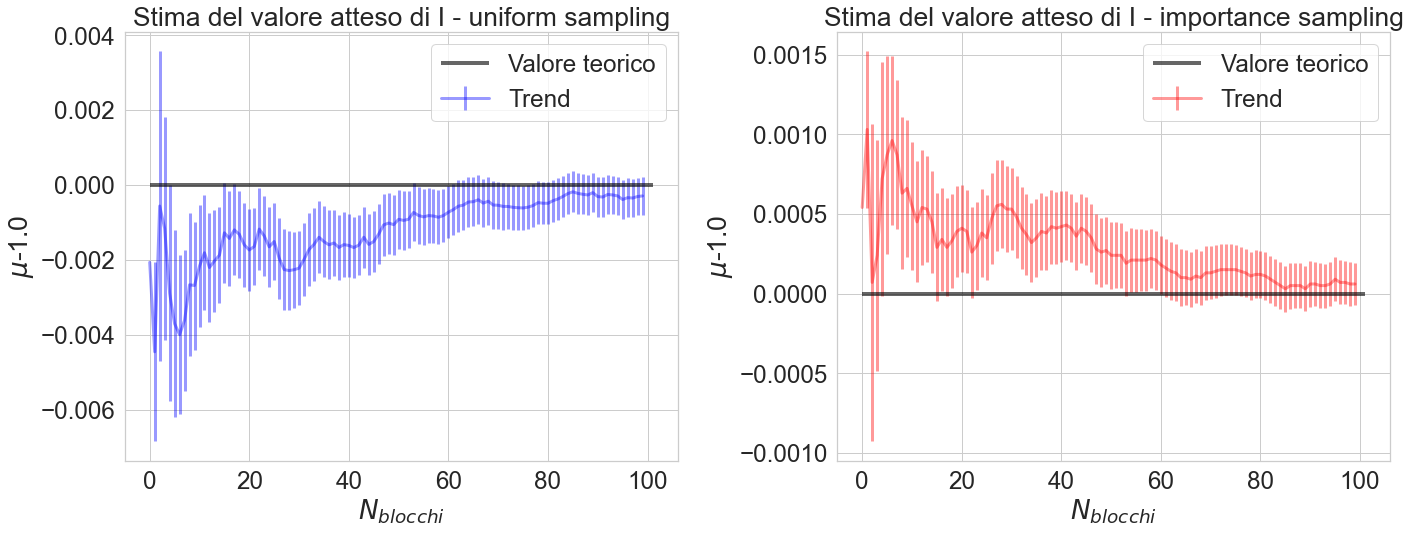

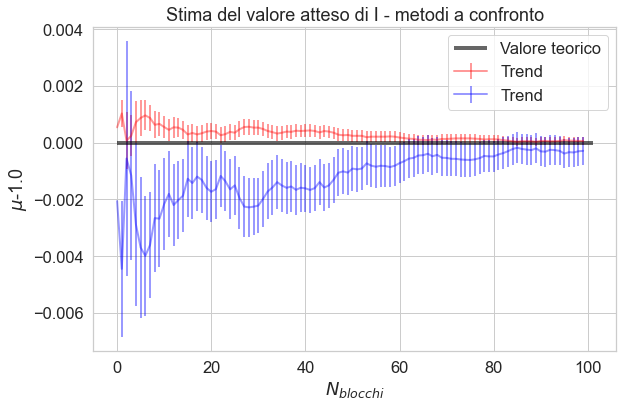

In [21]:
x = np.arange(100)
sns.set_theme(font_scale=2.2, style='whitegrid') 

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title("Stima del valore atteso di I - uniform sampling")
plt.errorbar(x, u_samp.T[0]-1, yerr=u_samp.T[1], color='blue', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,101, color='black', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel("$\mu$-1.0")
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.subplot(1,2,2)
plt.title("Stima del valore atteso di I - importance sampling")
plt.errorbar(x, i_samp.T[0]-1, yerr=i_samp.T[1], color='red', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,101, color='black', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel("$\mu$-1.0")
plt.xlabel("$N_{blocchi}$")
plt.legend()
plt.tight_layout()


sns.set_theme(font_scale=1.5, style='whitegrid') 
plt.figure(figsize=(9,6))
plt.title("Stima del valore atteso di I - metodi a confronto")
plt.errorbar(x, i_samp.T[0]-1, yerr=i_samp.T[1], color='red', alpha=0.4, label='Trend', linewidth=2)
plt.errorbar(x, u_samp.T[0]-1, yerr=u_samp.T[1], color='blue', alpha=0.4, label='Trend', linewidth=2)
plt.hlines(0,0,101, color='black', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel("$\mu$-1.0")
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.tight_layout()
plt.show()

__Figura 2:__ in alto a sinistra, stima progressiva del valore dell'integrale calcolata utilizzando la tecnica di uniform sampling. In alto a destra, stima progressiva di $I$ tramite importance sampling. In basso, stime progressive ottenute con i due metodi e messe a confronto. Risulta evidente come la scelta di una distribuzione di campionamento più simile all'integranda permetta, a parità di parametri del metodo utilizzato (numero di estrazioni per ogni calcolo di $I$ e numero di blocchi), di ottenere risultati migliori sin dal primo momento di applicazione della media a blocchi. Entrambi i risultati forniscono misure compatibili con il valore teorico atteso.

## 2.2 - Random Walks

In questa seconda parte dell'esercitazione abbiamo scritto un codice in grado di implementare un _random walk_ (RW). Lo abbiamo fatto in due modi diversi: (1) sviluppando il percorso del _walker_ su un reticolo tridimensionale discreto di lato $d$ e (2) permettendo al _walker_ di compiere passi di lunghezza $d$ lungo una direzione qualsiasi dello spazio tridimensionale. Nello specifico, ho implementato la classe `RanomWalk(..., string metric)` nella quale, specificando il valore di `metric` come `"continuum"` o `"discrete"`, viene definito il metodo tramite cui il _walker_ è guidato a muoversi nello spazio tridimensionale. In Figura 3 mostro il percorso seguito dal _walker_ nel caso di due cammini di cento passi ciascuno, rispettivamente su reticolo discreto e nel continuo. Spiego in breve come ho strutturato l'algorimo che esegue il RW nei due casi:
- __caso discreto:__ genero (utilizzando il generatore `random.cpp/h`) un numero `double` compreso tra `-dim` e `dim`, dove con `dim` intendo la dimensione dell'ipervolume in cui sto sviluppando il RW (in questo caso `dim=3`). A partire da questo singolo valore estraggo due informazioni: la parte intera del valore assoluto di questo numero (che indico con `index`), che corrisponde alla decisione del walker di percorrere un passo lungo una delle tre direzioni $x, y, z$. Il segno del numero (che indico con `versus`), che corrisponde al verso scelto dal walker nel compiere un passo lungo la direzione stabilita. A questo punto viene aggiornata la posizione del walker nella coordinata stabilita dall'algoritmo: `_pos.at(index) += versus * d`.
- __caso continuo:__ genero uniformemente i valori degli angoli $\theta \in [0,2\pi]$ e $\phi \in [0,\pi]$ necessari per poter calcolare le coordinate cartesiane di un vettore tridimensionale avente modulo $d$ fissato; a questo punto calcolo le tre coordinate corrispondenti alla nuova posizione del punto. Riporto la coordinata $x$ a titolo d'esempio: `_pos.at(0) += d * cos(phi) * sin(theta)`.

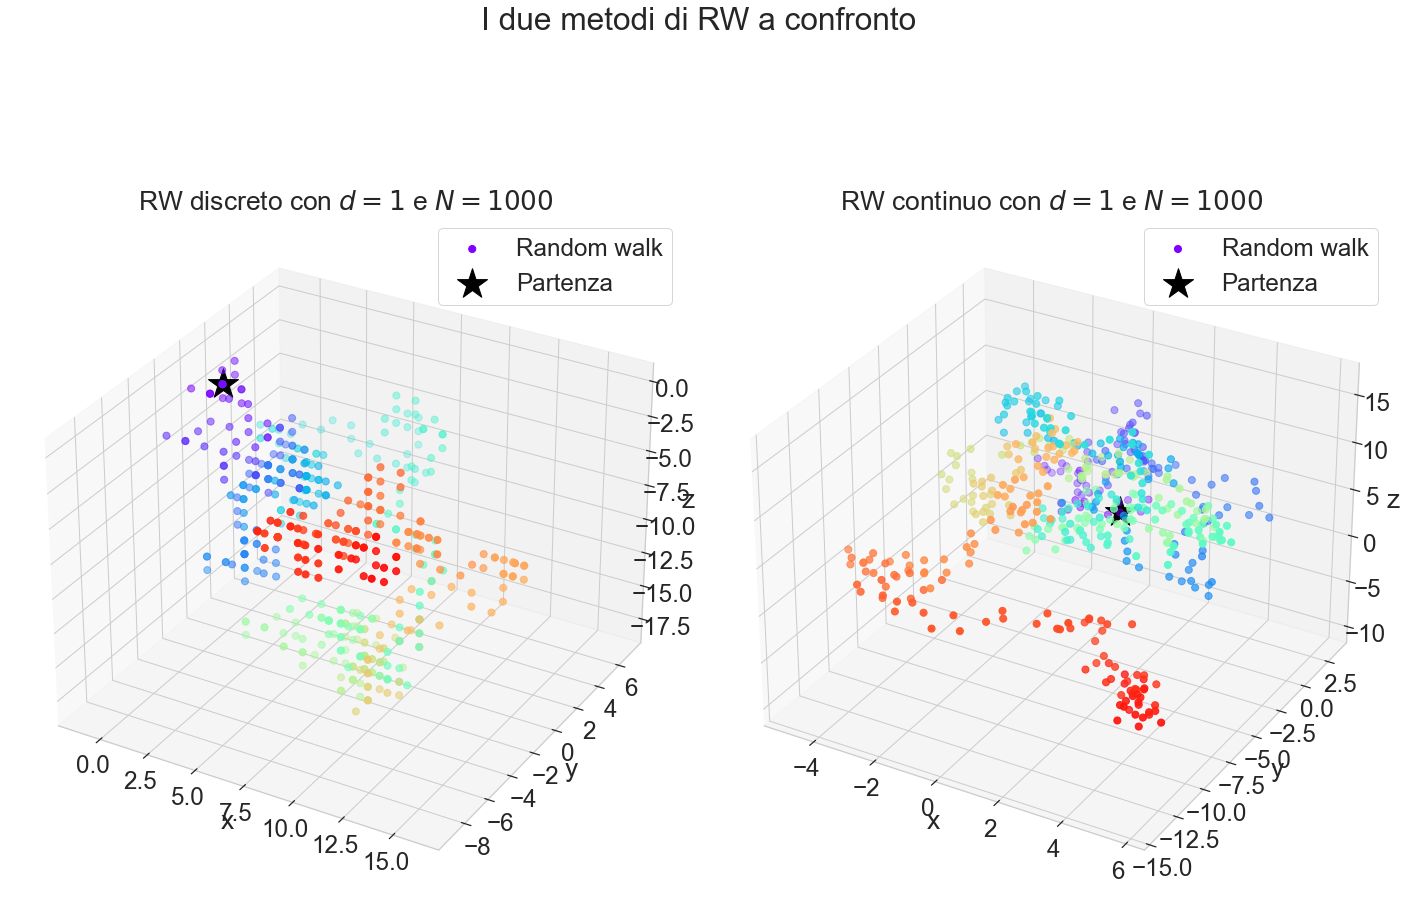

In [186]:
colors = cm.rainbow(np.linspace(0, 1, 500))
sns.set_theme(font_scale=2.2, style='whitegrid') 


fig = plt.figure(figsize=(20,15))
plt.suptitle('I due metodi di RW a confronto')

ax = fig.add_subplot(1,2,1, projection='3d')
plt.title('RW discreto con $d=1$ e $N=1000$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(dis_rw.T[0], dis_rw.T[1], dis_rw.T[2], color=colors, s=50, label='Random walk')
ax.scatter(dis_rw.T[0][0], dis_rw.T[1][0], dis_rw.T[2][0], color='black', s=1000, marker='*', label='Partenza')
plt.legend()

ax1 = fig.add_subplot(1,2,2, projection='3d')
plt.title('RW continuo con $d=1$ e $N=1000$')
ax1.scatter(con_rw.T[0], con_rw.T[1], con_rw.T[2], color=colors, s=50, label='Random walk')
ax1.scatter(con_rw.T[0][0], con_rw.T[1][0], con_rw.T[2][0], color='black', s=1000, marker='*', label='Partenza')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
plt.legend()

plt.tight_layout()
plt.show()

__Figura 3:__ a sinistra, RW composto da cento passi su un reticolo discreto di passo `d=1`, a destra, RW composto da 100 passi di lunghezza `d=1` svolti nello spazio continuo. In entrambe le rappresentazioni la scala cromatica (dal violetto al rosso) rappresenta l'ordine della sequenza con cui sono stati eseguiti i passi.


### Stimare $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$

L'obiettivo di questo secondo esercizio è quello di effettuare la stima di $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$, ovvero la distanza media dall'origine raggiunta dall'_walker_ in funzione del numero di passi svolti (da 1 a 100 passi). Per farlo, ho nuovamente utilizzato il metodo `blocking`; questa volta, l'implementazione concreta della misura effettuata nella stima a blocchi (ed espressa come di consueto nel metodo `get_measure()`), consiste nel compimento di un RW (discreto o continuo a seconda del caso) composto da cento passi. Dopo aver compiuto l'i-esimo passo, l'_walker_ si trova nella posizione $\vec{x}_i = (x_i, y_i, z_i)$. A questo punto salvo nell'i-esimo elemento di un vettore delle distanze chiamato `step_distance` la distanza raggiunta e calcolata come $D_i = \sqrt{x_i^2+y_i^2+z_i^2}$. Il vettore `step_distance` consiste in una singola realizzazione dell'esperimento. Il metodo `blocking`, che è pensato per adeguarsi alla dimensione del vettore misura fornito, svolge tante medie a blocchi quante variabili misurate vengono fornite: in questo caso cento stime diverse, una per ogni i-esimo passo dei cammini. Ho salvato i risultati ottenuti a seguito dell'ultimo passo dell'esecuzione del blocking.  

Per mezzo del metodo spiegato ho dunque calcolato il valore di aspettazione di $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}\equiv D_{RW}$ e la sua incertezza tramite la propagazione degli errori: $$\sigma_{D_{RW}}=\frac{\sigma_{\langle |\vec{r}_N|^2 \rangle}}{2  D_{RW}}.$$

--- 

Ho effettuato questa operazione utilizzando entrambi i metodi `discrete` e `continuum`; nel farlo ho calcolato inizialmente la media a blocchi eseguendo $M=10^4$ realizzazioni di RW ciascuno di $n=100$ passi e utilizzando $N=100$ blocchi. Per evitare problemi di correlazione ho in seguito deciso di aumentare la taglia $L=M/N$ dei blocchi. Sono passato da una taglia iniziale $L=10^4/10^2=10^2$ ad una taglia $L=5\cdot 10^5/10^2= 10^3$.

---

Come ultimo passaggio di questo secondo esercizio ho eseguito un fit sui risultati ottenuti. Come suggerito nella consegna dell'esercizio, ho svolto questa interpolazione a partire da una forma funzionale del tipo $y=k\sqrt{N}$, dove $N$ corrisponde al numero di passi svolti dal _walker_.

In [182]:
def sqrt_fit(N,k):
    return k*np.sqrt(N)

In [187]:
x = np.arange(100)
y = block_disc.T[0]
z = block_cont.T[0]

popt, pcov = curve_fit(sqrt_fit, x, y)
popt2, pcov2 = curve_fit(sqrt_fit, x, z)

y_pred = sqrt_fit(x, *popt)
z_pred = sqrt_fit(x, *popt2)

print('Parametro k ottenuto nel fit relativo a RW discreto: ', popt)
print('Parametro k ottenuto nel fit relativo a RW continuo: ', popt2)

Parametro k ottenuto nel fit relativo a RW discreto:  [0.99866909]
Parametro k ottenuto nel fit relativo a RW continuo:  [0.9970576]


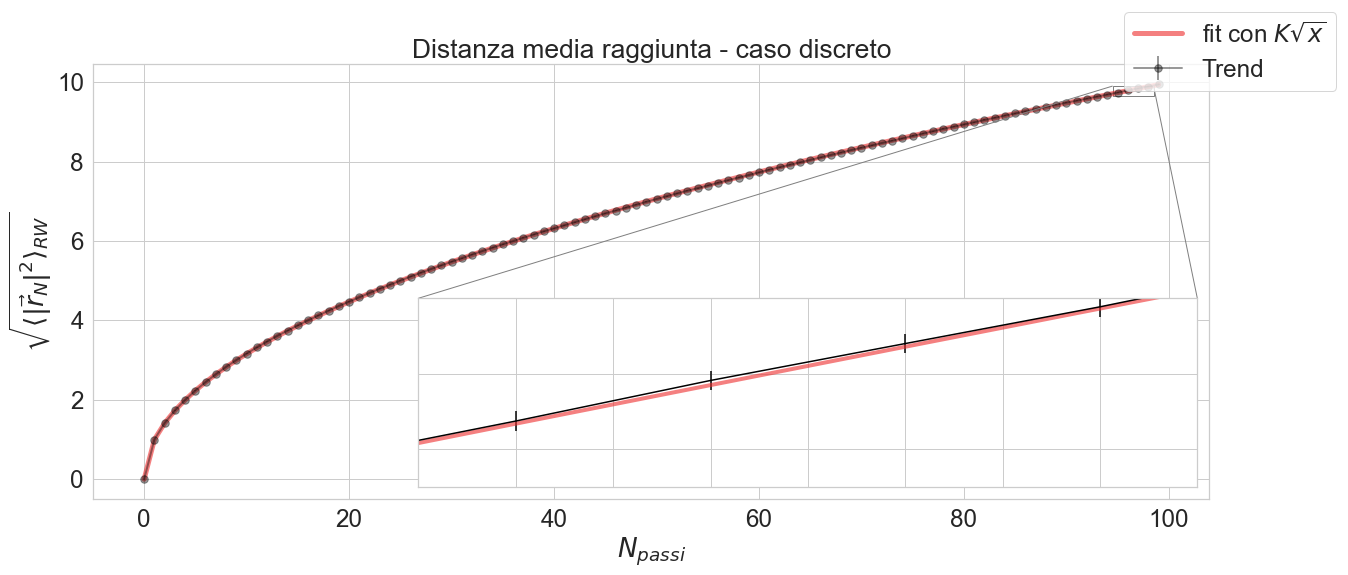

In [188]:
fig, ax = plt.subplots(figsize=[20, 8])
plt.title("Distanza media raggiunta - caso discreto")
plt.ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle _{RW}}$')
plt.xlabel("$N_{passi}$")

axins=zoomed_inset_axes(ax,19,loc=4)   
x1, x2, y1, y2 = 94.5, 98.5, 9.65, 9.9
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

ax.errorbar(x, block_disc.T[0], yerr=block_disc.T[1], color='black', alpha=0.4, label='Trend', linewidth=2, markersize=15,marker='.')
ax.plot(x, y_pred, color='#EE2C2C', linestyle='-', label="fit con $K\sqrt{x}$", linewidth=5, alpha=0.6)
axins.plot(x, y_pred, color='#EE2C2C', linestyle='-', linewidth=4, alpha=0.6)
axins.errorbar(x,block_disc.T[0],yerr=block_disc.T[1], color='black')
mark_inset(ax,axins,loc1=1,loc2=2,fc='none',ec='0.5')
fig.legend(loc=1)


plt.show()

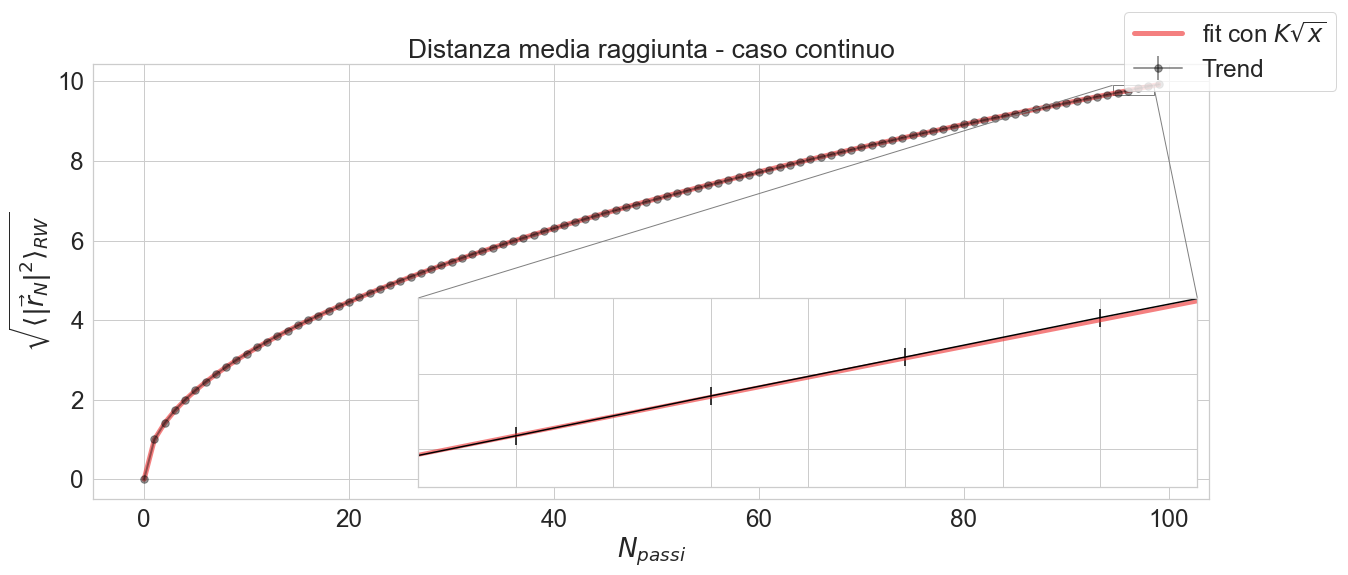

In [189]:
fig, ax = plt.subplots(figsize=[20, 8])
plt.title("Distanza media raggiunta - caso continuo")
plt.ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle _{RW}}$')
plt.xlabel("$N_{passi}$")

axins=zoomed_inset_axes(ax,19,loc=4)   
x1, x2, y1, y2 = 94.5, 98.5, 9.65, 9.9
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

ax.errorbar(x, block_cont.T[0], yerr=block_cont.T[1], color='black', alpha=0.4, label='Trend', linewidth=2, markersize=15,marker='.')
ax.plot(x, z_pred, color='#EE2C2C', linestyle='-', label="fit con $K\sqrt{x}$", linewidth=5, alpha=0.6)
axins.plot(x, z_pred, color='#EE2C2C', linestyle='-', linewidth=4, alpha=0.6)
axins.errorbar(x,block_cont.T[0],yerr=block_cont.T[1], color='black')
mark_inset(ax,axins,loc1=1,loc2=2,fc='none',ec='0.5')
fig.legend(loc=1)


plt.show()

__Figura 4:__ in alto, valore della radice della distanza media raggiunta dal _walker_ in funzione del numero di passi svolti in un RW discreto. In basso, la stessa rappresentazione nel caso di RW continuo. Entrambi i grafici mostrano che i valori misurati seguono un andamento riconducibile alla forma funzionale $f(N_{passi})=k\sqrt{N_{passi}}$. Questo lo possiamo verificare sovrapponendo alle misure effettuate le curve ottenute tramite interpolazione, che ho rappresentato in rosso nei grafici. Questi risultati mi portano dunque a rispondere che il sistema evolve in modo diffusivo.

Per mettere definitivamente a confronto le performance dei due metodi ho deciso di costruire un grafico dell'incertezza calcolata nella misura della distanza media raggiunta ad un certo passo in funzione del numero di passi svolti. Ho sovrapposto i valori ottenuti per entrambi i metodi così da metterli a confronto. Ho inoltre rappresentato il valore della differenza tra l'errore commesso nel caso discreto e nel caso continuo.

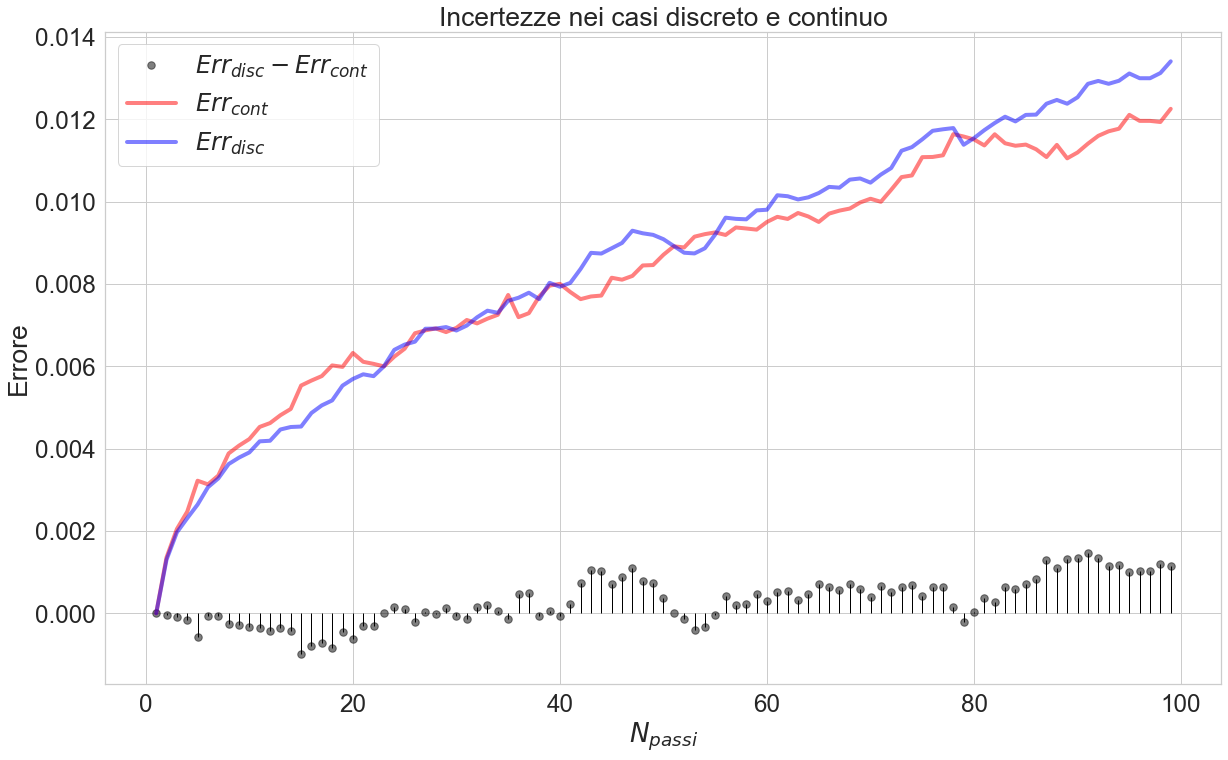

In [190]:
plt.figure(figsize=(20,12))

err_cont = block_cont.T[1]
err_disc = block_disc.T[1]
plt.title('Incertezze nei casi discreto e continuo')

plt.plot(err_disc-err_cont, linestyle= " ", marker=".", markersize=15, alpha=0.5, label=r'$Err_{disc}-Err_{cont}$', color='black')
plt.plot(err_cont, linewidth=4, alpha=0.5, label=r'$Err_{cont}$', color='red')
plt.plot(err_disc, linewidth=4, alpha=0.5, label=r'$Err_{disc}$', color='blue')
for i in range(99):
    plt.vlines(i+1, 0, err_disc[i+1]-err_cont[i+1], color='black', linewidth=1)
plt.legend()
plt.ylabel('Errore')
plt.xlabel(r'$N_{passi}$')
plt.show()

__Figura 5:__ in rosso, incertezza calcolata nella misura della distanza media raggiunta in funzione del numero di passi svolti nel caso di RW a passo continuo. In blu, la medesima rappresentazione nel caso di RW a passo discreto. In nero, la differenza dei due valori calcolata come $Err_{disc}-Err_{cont}$. Notiamo che gli ordini di grandezza dei due errori sono paragonabili e lo è anche l'andamento delle due curve che, anche in questo caso, riflette nel calcolo dell'incertezza il comportamento diffusivo del sistema.